In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
cblind_palete = sns.color_palette("colorblind", as_cmap=True)
learner_colors = {
    "SLearner": cblind_palete[0],
    "TLearner": cblind_palete[1],
    "XLearner": cblind_palete[2],
    "TARNet": cblind_palete[3],
    'CFRNet_0.01': cblind_palete[4],
    "CFRNet_0.001": cblind_palete[6],
    'CFRNet_0.0001': cblind_palete[9],
    "DRLearner": cblind_palete[8],
    "RALearner": cblind_palete[9],
    "Truth": cblind_palete[9],
}

learner_linestyles = {
    "SLearner": "-",
    "TLearner": "--",
    "XLearner": ":",
    "TARNet": "-.",
    "XLearner": "--",
    "CFRNet_0.01": "-",
    "CFRNet_0.001": ":",
    "CFRNet_0.0001": "--",
    "DRLearner": "-",
    "RALearner": "--",
    "Truth": ":",
}


learner_markers = {
    "SLearner": "d",
    "TLearner": "o",
    "XLearner": "^",
    "TARNet": "*",
    "XLearner": "D",
    "CFRNet_0.01": "8",
    "CFRNet_0.001": "s",
    "CFRNet_0.0001": "x",
    "DRLearner": "x",
    "RALearner": "H",
    "Truth": "<",
}

datasets_names_map = {
    "tcga_100": "TCGA", 
    "twins": "Twins", 
    "news_100": "News", 
    "acic": "ACIC2016", 
    "pred": "Predictive confounding", 
    "prog": "Prognostic confounding", 
    "irrelevant_var": "Non-confounded propensity"}

metric_names_map = {
    'Pred features ACC': r'$\mathrm{Attr}_{\mathrm{pred}}$',
    'Prog features ACC': r'$\mathrm{Attr}_{\mathrm{prog}}$',
    'PEHE': 'PEHE',
}

learners_names_map = {
    "TLearner":"T-Learner", 
    "SLearner": "S-Learner", 
    "TARNet": "TARNet",  
    "DRLearner": "DR-Learner", 
    "XLearner": "X-Learner", 
    "TARNet": "TARNet",
    "CFRNet_0.001": r'$\mathrm{CFRNet}(\gamma=0.001)$',  
    "CFRNet_0.01": r'$\mathrm{CFRNet}(\gamma=0.1)$', 
    "CFRNet_0.0001": r'$\mathrm{CFRNet}(\gamma=0.0001)$',
}


def plot_results_datasets(results_df_map, x_axis, x_label_name, x_values_to_plot, metrics_list, learners_list, figsize, legend_position, sharey=False, legend_rows=1): 
    font_size=20
    fig, axs = plt.subplots(len(metrics_list), len(results_df_map.keys()), figsize=figsize, squeeze=False, sharey=sharey)
    plt.gcf().subplots_adjust(bottom=0.15)
    for dataset_id, dataset in enumerate(results_df_map.keys()):
        results_df = results_df_map[dataset]
        for metric_id, metric in enumerate(metrics_list):
            for learner_id, learner in enumerate(learners_list):
                sub_df = results_df.loc[(results_df["Learner"] == learner)][[x_axis, metric]]

                sub_df = sub_df[sub_df[x_axis].isin(x_values_to_plot)]

                sub_df_mean = sub_df.groupby(x_axis).agg('mean').reset_index()
                sub_df_std = sub_df.groupby(x_axis).agg('std').reset_index()

                x_values = sub_df_mean.loc[:, x_axis].values
                y_values = sub_df_mean.loc[:, metric].values
                y_err = sub_df_std.loc[:, metric].values / (np.sqrt(len(seeds_list)))
                
                axs[metric_id][dataset_id].plot(x_values, y_values, label=learners_names_map[learner], 
                                                          color=learner_colors[learner], linestyle=learner_linestyles[learner], marker=learner_markers[learner])
                axs[metric_id][dataset_id].fill_between(x_values, y_values-y_err, y_values+y_err, alpha=0.1, color=learner_colors[learner])
                axs[metric_id][0].set_ylabel(metric_names_map[metric], fontsize=font_size)
                axs[metric_id][dataset_id].tick_params(axis='x', labelsize=font_size-8)
                axs[metric_id][dataset_id].tick_params(axis='y', labelsize=font_size-8)

        axs[0][dataset_id].set_title(datasets_names_map[dataset], fontsize=font_size)
        axs[metric_id][dataset_id].set_xlabel(x_label_name, fontsize=font_size)
    
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(
        lines[:len(learners_list)],
        labels[:len(learners_list)],
        bbox_to_anchor=(legend_position, 0.0),
        ncol=len(learners_list) if legend_rows == 1 else int((len(learners_list)+1)/legend_rows),
        prop={'size': font_size}
    )
    fig.tight_layout()
    
    plt.show()
    return fig

In [3]:
def aggregate_results_and_plot_predictive_sensitivity(
    datasets_list, 
    num_important_features_list, 
    explainer, 
    metrics_list, 
    synthetic_simulator_type, 
    binary_outcome, 
    seeds_list
):
    results_path = 'results/predictive_sensitivity'
    results_df_map = {}
    
    figsize = (18, 9)
    legend_position = 0.97
    
    for dataset_id, dataset in enumerate(datasets_list):
        results_df_list = []
        for seed in seeds_list:
            results_filename = f"predictive_scale_{dataset}_{num_important_features_list[dataset_id]}_{synthetic_simulator_type}_random_True_binary_{binary_outcome}-seed{seed}.csv"
            results_df_list.append(pd.read_csv(results_path + '/' + results_filename, index_col=None))
        results_df = pd.concat(results_df_list)

        results_df = results_df[results_df['Explainer']==explainer]
        results_df_map[dataset] = results_df

    fig = plot_results_datasets(results_df_map=results_df_map, x_axis='Predictive Scale', x_label_name=r'$\omega_{\mathrm{pred}}$', 
                 x_values_to_plot=[1e-3, 1e-2, 1e-1, 0.5, 1], metrics_list=metrics_list,
                 learners_list=["TLearner", "SLearner",  "DRLearner", "XLearner",  "TARNet",], 
                 figsize=figsize, legend_position=legend_position)
    fig.savefig("results/results_figs/" + "predictive_scale" + "_" + explainer + ".pdf", bbox_inches="tight")
        
def aggregate_results_and_plot_nonlinearity_sensitivity(
    datasets_list, 
    num_important_features_list, 
    explainer, 
    metrics_list, 
    binary_outcome, 
    seeds_list
):
    results_path = 'results/nonlinearity_sensitivity/random'
    results_df_map = {}
    
    figsize = (18, 6)
    legend_position = 0.97
    
    for dataset_id, dataset in enumerate(datasets_list):
        results_df_list = []
        for seed in seeds_list:
            results_filename = f"{dataset}_{num_important_features_list[dataset_id]}_binary_{binary_outcome}-seed{seed}.csv"
            results_df_list.append(pd.read_csv(results_path + '/' + results_filename, index_col=None))
        results_df = pd.concat(results_df_list)
        results_df = results_df[results_df['Explainer']==explainer]
        results_df_map[dataset] = results_df
    
    fig = plot_results_datasets(results_df_map=results_df_map, x_axis="Nonlinearity Scale", x_label_name=r'$\omega_{\mathrm{nl}}$', 
                 x_values_to_plot=[0.0, 0.2, 0.5, 0.7, 1.0], metrics_list=metrics_list,
                 learners_list=["TLearner", "SLearner", "DRLearner", "XLearner", "TARNet"], 
                 figsize=figsize, legend_position=legend_position)
    fig.savefig("results/results_figs/" + "nonlinearity_sensitivity" + "_" + explainer + ".pdf", bbox_inches="tight")

    
def aggregate_results_and_plot_propensity_sensitivity(
    dataset, 
    num_important_features, 
    explainer, 
    metrics_list, 
    binary_outcome, 
    simulation, 
    train_ratio, 
    propensity_type_list, 
    seeds_list
):
    results_path = 'results/propensity_sensitivity/' + str(simulation)
    results_df_map = {}
    
    figsize = (12, 8)
    legend_position = 1.1
    for propensity_type_id, propensity_type in enumerate(propensity_type_list):
        results_df_list = []
        for seed in seeds_list:
            results_filename = f"propensity_scale_{dataset}_{num_important_features}_proptype_{propensity_type}_predscl_1.0_nonlinscl_0.5_trainratio_{train_ratio}_binary_{binary_outcome}-seed{seed}.csv"
            results_df_list.append(pd.read_csv(results_path + '/' + results_filename, index_col=None))
        results_df = pd.concat(results_df_list)
        results_df = results_df[results_df['Explainer']==explainer]
        results_df_map[propensity_type] = results_df
    
    fig = plot_results_datasets(results_df_map=results_df_map, x_axis="Propensity Scale", x_label_name=r'$\omega_{\pi}$', 
                 x_values_to_plot=[0, 1e-1, 1, 2, 5, 10], metrics_list=metrics_list,
                 learners_list=[
                    "TLearner",
                    "TARNet",
                    "SLearner",
                    "CFRNet_0.01",
                    "DRLearner",
                    "CFRNet_0.001",
                    "XLearner",
                    "CFRNet_0.0001"
                ],
                 figsize=figsize, legend_position=legend_position, sharey="row", legend_rows=2)
    fig.savefig("results/results_figs/" + "propensity_sensitivity" + "_" + simulation + "_" + str(train_ratio) + "_" + dataset + ".pdf", bbox_inches="tight")

# Linear + random

In [4]:
seeds_list = list(range(1, 6))
metrics_to_plot = ['Pred features ACC', 'Prog features ACC', 'PEHE']
explainer='shapley_value_sampling'
datasets_list = ['tcga_100', 'twins', 'news_100', 'acic']
num_important_features_list = [20, 8, 20, 10]

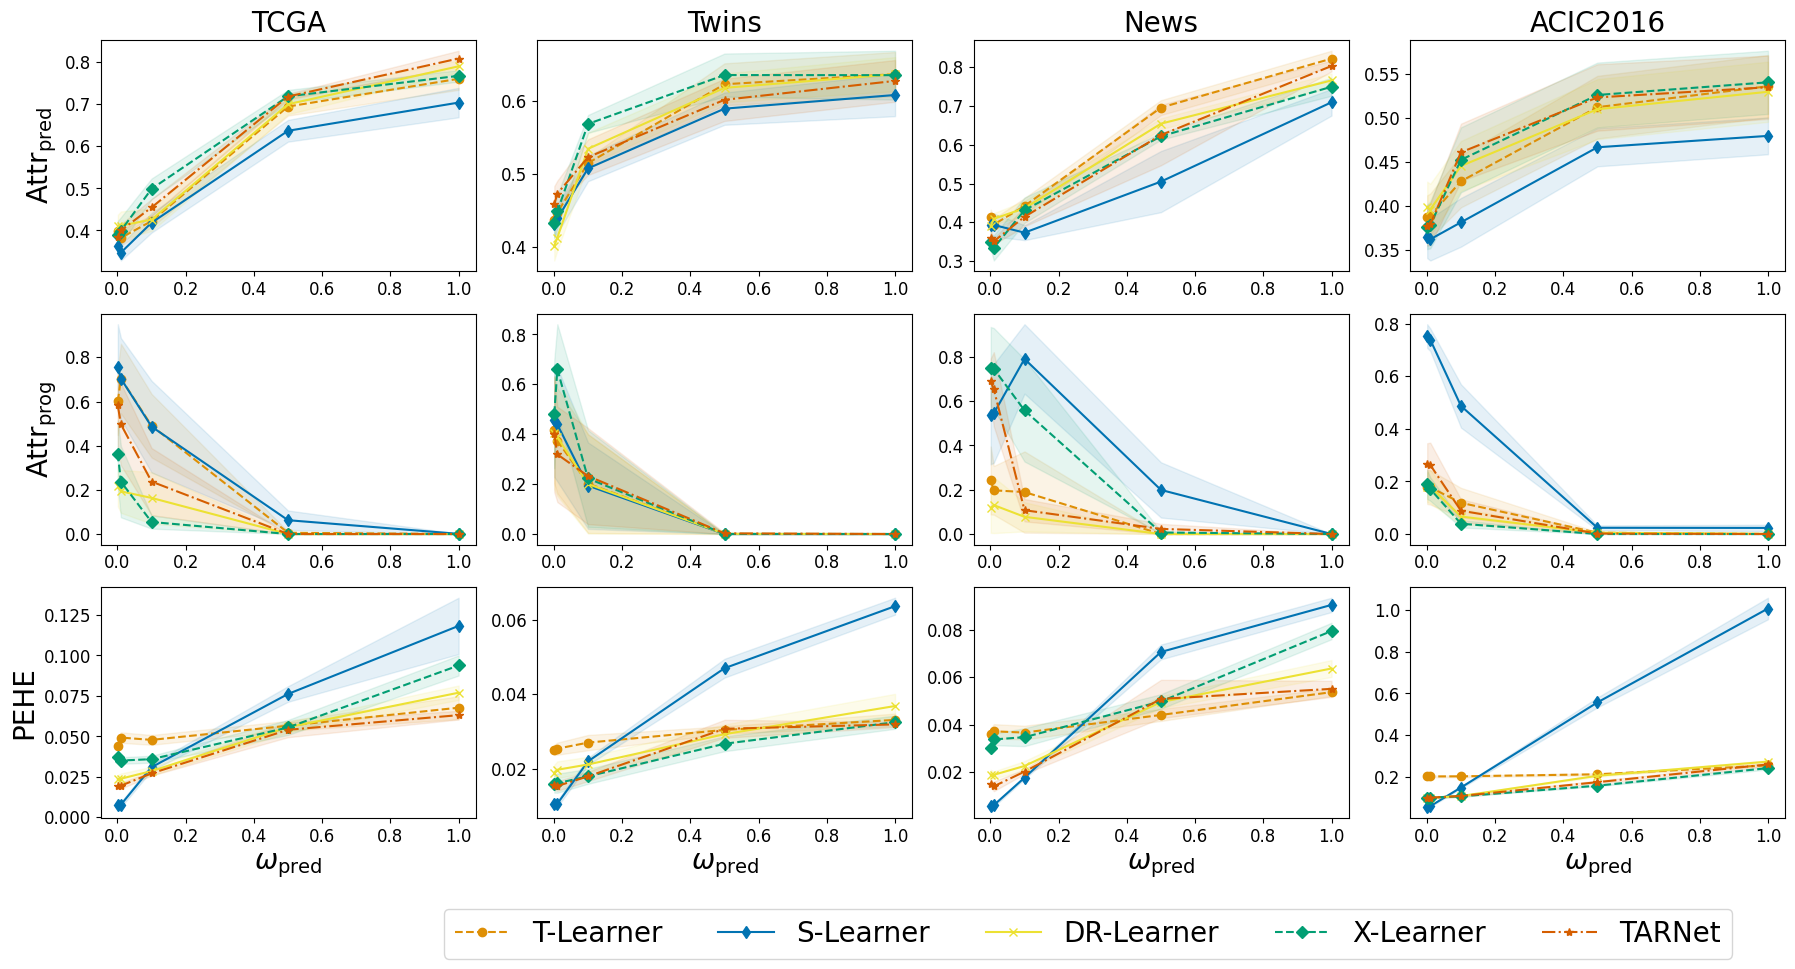

In [5]:
aggregate_results_and_plot_predictive_sensitivity(datasets_list=datasets_list, num_important_features_list=num_important_features_list, explainer=explainer, metrics_list=metrics_to_plot, synthetic_simulator_type='linear', 
                                                  binary_outcome='False', seeds_list=seeds_list)

# Non-linear sensitivity

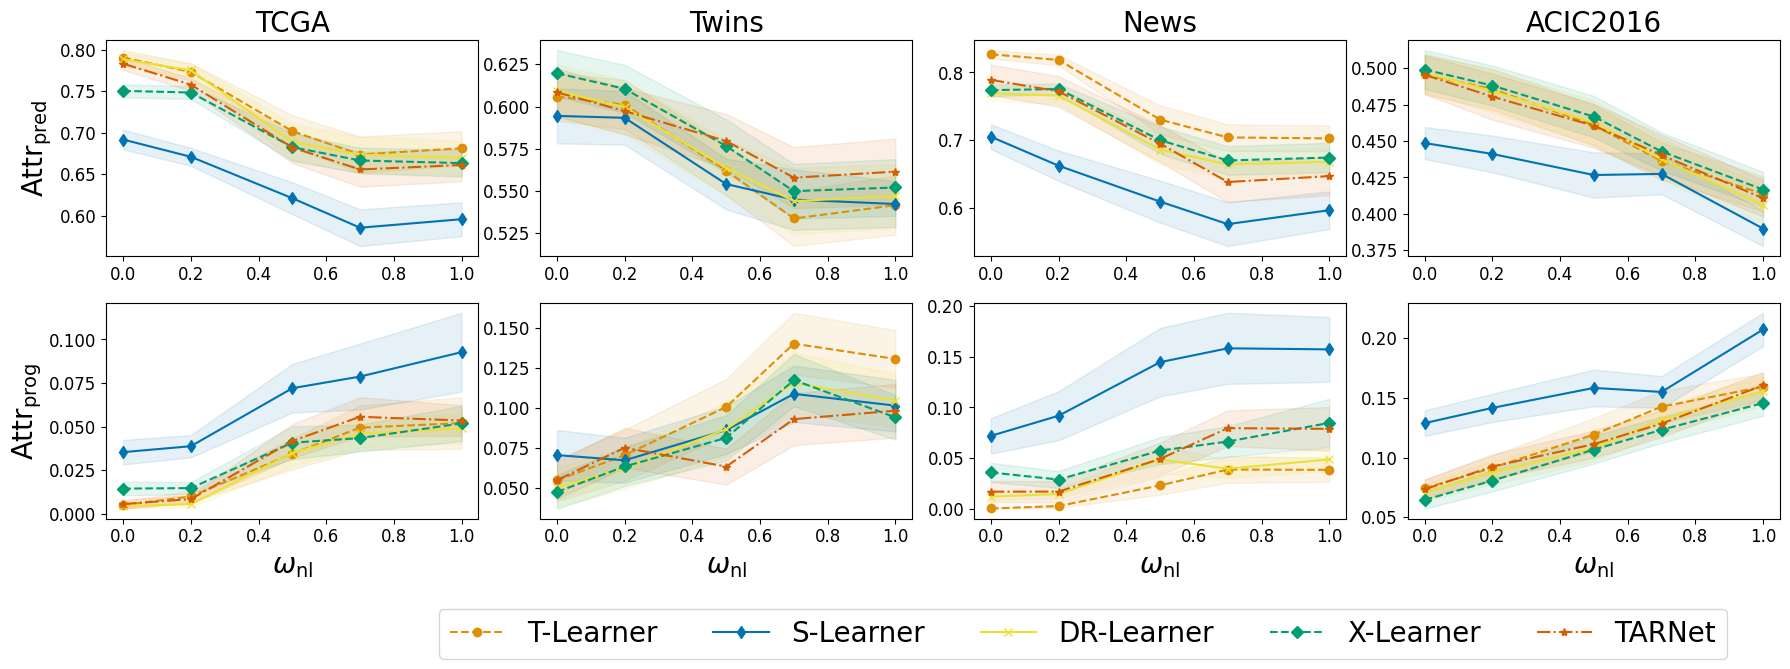

In [6]:
seeds_list = list(range(1, 30))
metrics_to_plot = ['Pred features ACC', 'Prog features ACC',]
aggregate_results_and_plot_nonlinearity_sensitivity(datasets_list=datasets_list, num_important_features_list=num_important_features_list, explainer=explainer, metrics_list=metrics_to_plot, 
                                                  binary_outcome='False', seeds_list=seeds_list)

# Propensity sensitivity

In [7]:
propensity_type_list = ['pred', 'prog', 'irrelevant_var']
metrics_to_plot = ['Pred features ACC', 'PEHE']
dataset = 'news_100'
num_important_features = 20
seeds_list = list(range(1, 30))
simulation = 'linear'
train_ratio = 0.8

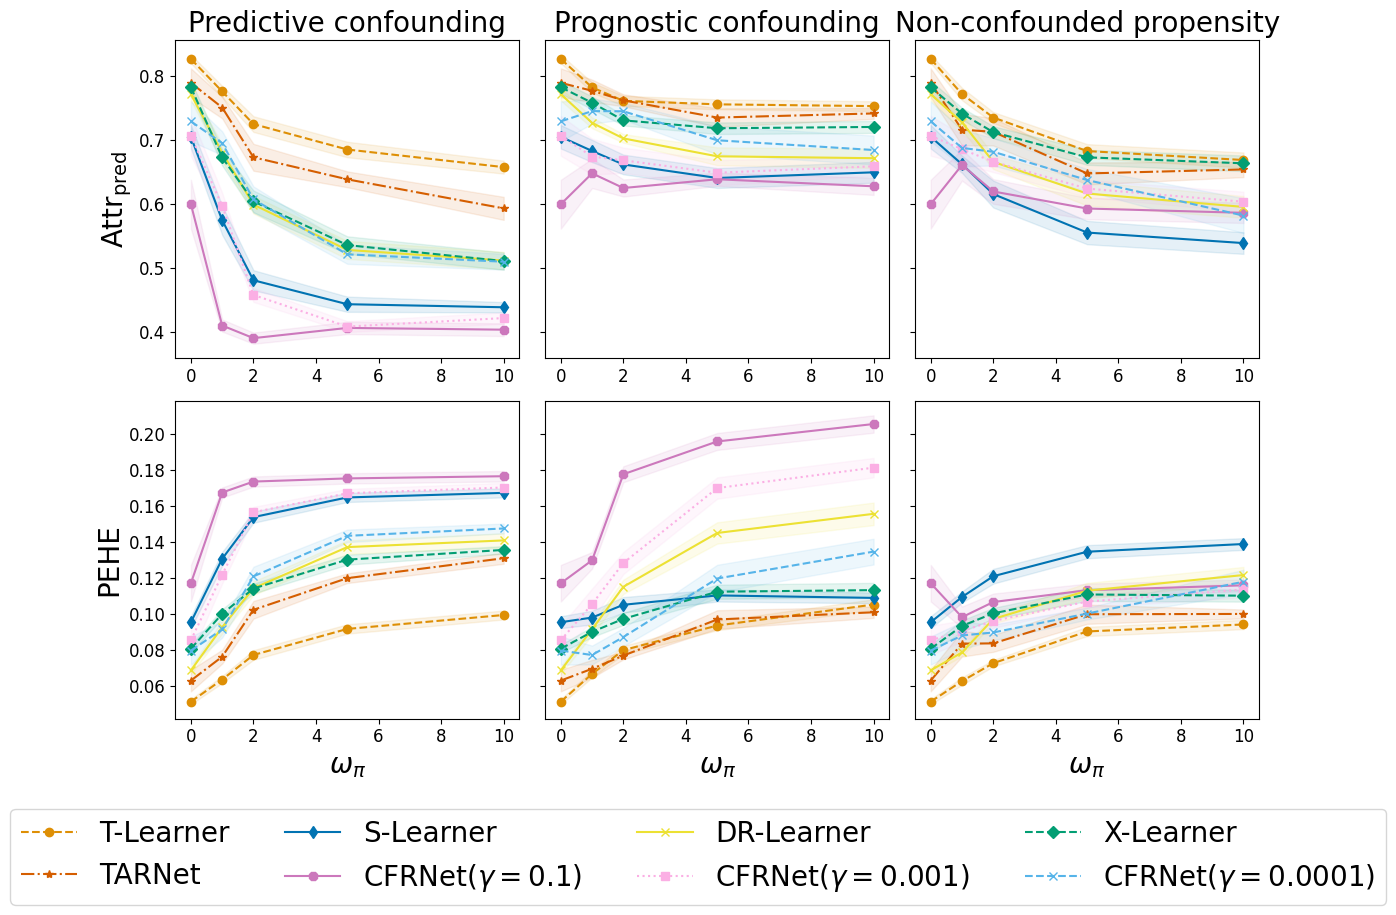

In [8]:
aggregate_results_and_plot_propensity_sensitivity(
    dataset=dataset,
    num_important_features=num_important_features,
    propensity_type_list=propensity_type_list,
    explainer=explainer,
    metrics_list=metrics_to_plot,
    binary_outcome='False',
    simulation=simulation,
    train_ratio=train_ratio,
    seeds_list=seeds_list
)